## Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from cleantext import clean
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import spacy, nltk
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import wordcloud
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Flatten, MaxPooling1D, Bidirectional, TextVectorization, Embedding, Dense, Input
from tensorflow.keras import Model, Sequential
import joblib


In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
nltk.download("stopwords")
stop_words = stopwords.words('english')
stop_words.extend(["I", "im", "lol", "ur"])
stop_words.extend(list(string.ascii_letters))
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import data

In [4]:
data = pd.read_csv("./sms_spam/spam.csv", encoding = 'latin')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
data = data[["v1", "v2"]]
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data.rename(columns={
    'v1': "label",
    "v2": "sms_text"
}, inplace=True)

In [7]:
data["label"] = data["label"].map({
    "ham": 0,
    "spam": 1
})

## Text preprocessing

In [8]:
def clean_text(text):
    cleaned_text = clean(text, fix_unicode = True, to_ascii = True, lower = True, no_line_breaks = True, no_urls = True, no_emails = True,
                 no_phone_numbers =True, no_digits = True, no_currency_symbols = True, no_punct = True, no_emoji=True, 
                  replace_with_digit = "" )
    
    refined_text = " ".join([token.lemma_ for token in nlp(cleaned_text) if token.lemma_ not in stop_words])
    
    refined_text = refined_text.replace("< email >", "<email>")
    refined_text = refined_text.replace("< url >", "<url>")
    refined_text = refined_text.replace("< cur >", "<cur>")
    refined_text = refined_text.replace("< phone >", "<phone>")
    return refined_text

In [9]:
data["sms_text"] = data["sms_text"].apply(clean_text)

In [10]:
def remove_blank_and_small_sents(val):
    if len(val[1].split()) < 2:                       # If the no of words <2
        if val[0] != 1 or len(val[1].split()) == 0:       # As the no of spam sms is very small I am allowing small spam sms
            return False
        else: 
            return True
    return True

In [11]:
data = data[data.apply(remove_blank_and_small_sents, axis = 1)]
data.tail()

,label,sms_text
5567,1,nd time try contact win <cur> pound prize clai...
5568,0,go esplanade fr home
5569,0,pity mood soany suggestion
5570,0,guy bitching act like interested buy something...
5571,0,rofl true name


## EDA

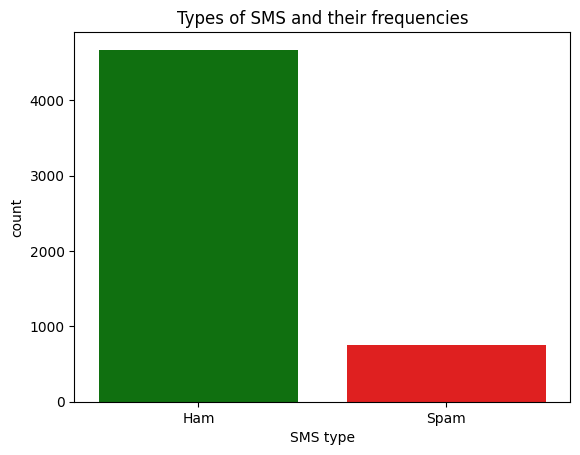

In [12]:
sns.countplot(x = data["label"], palette = ["green", "red"])
plt.xticks((0, 1), ("Ham", "Spam"))
plt.xlabel("SMS type")
plt.title("Types of SMS and their frequencies");

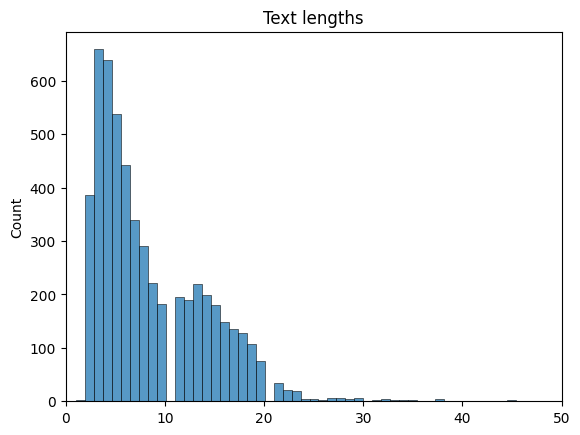

In [50]:
text_length = [len(t.split()) for t in data['sms_text']]
sns.histplot(text_length)
plt.xlim((0, 50));
plt.title("Text lengths");

In [51]:
ham_texts = data[data["label"] == 0]["sms_text"].values
ham_words = " ".join(ham_texts)

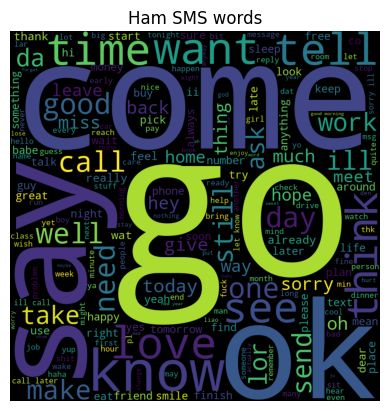

In [15]:
ham_wordcloud = wordcloud.WordCloud(
    width = 800,
    height = 800,
    min_font_size = 10
).generate(ham_words)

plt.imshow(ham_wordcloud)
plt.title("Ham SMS words")
plt.axis("off");

In [16]:
spam_texts = data[data["label"] == 1]["sms_text"].values
spam_words = " ".join(spam_texts)

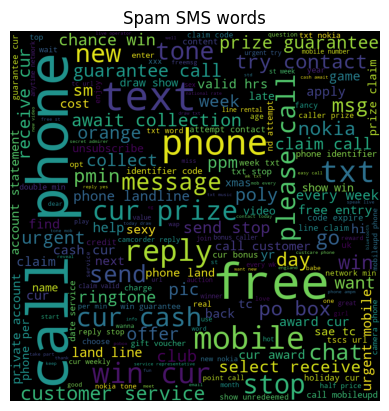

In [17]:
spam_wordcloud = wordcloud.WordCloud(
    width = 800,
    height = 800,
    min_font_size = 10
).generate(spam_words)

plt.imshow(spam_wordcloud)
plt.title("Spam SMS words")
plt.axis("off");

## Train-test split

In [12]:
X = data["sms_text"].values
y = data["label"].values

X.shape, y.shape

((5418,), (5418,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4063,), (4063,), (1355,), (1355,))

## Modelling Experiments

#### Some important functions

In [14]:
def model_performance(y_test, y_pred):
    return{
        'accuracy': np.round(accuracy_score(y_test, y_pred), 3),
        'recall': np.round(recall_score(y_test, y_pred), 3),
        'precision': np.round(precision_score(y_test, y_pred), 3),
        'f1_score': np.round(f1_score(y_test, y_pred), 3),
    }

In [155]:
def plot_model_performance(model_hist):
    plt.figure(figsize = (10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(model_hist.epoch, model_hist.history["loss"], label = 'train_loss')
    plt.plot(model_hist.epoch, model_hist.history["val_loss"], label = 'test_loss')
    plt.xticks((model_hist.epoch), np.array(model_hist.epoch) + 1)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(model_hist.epoch, model_hist.history["accuracy"], label = 'train_accuracy')
    plt.plot(model_hist.epoch, model_hist.history["val_accuracy"], label = 'test_accuracy')
    plt.xticks((model_hist.epoch), np.array(model_hist.epoch) + 1)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.tight_layout()

In [110]:
def model_ckpt(model_name):
    return ModelCheckpoint(
        filepath = f'./saved_models/{model_name}',
        monitor = 'val_accuracy', 
        save_best_only = True
    )

### Model1: `MultiNomialNB`

In [15]:
tfidf = TfidfVectorizer(min_df = 2)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [22]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [23]:
y_pred = mnb.predict(X_test_tfidf)
model_performance(y_test, y_pred)

{'accuracy': 0.97, 'recall': 0.786, 'precision': 0.978, 'f1_score': 0.872}

### Model2: `SVM`

In [24]:
svc = SVC()
svc.fit(X_train_tfidf, y_train)

SVC()

In [25]:
y_pred2 = svc.predict(X_test_tfidf)
model_performance(y_test, y_pred2)

{'accuracy': 0.979, 'recall': 0.855, 'precision': 0.98, 'f1_score': 0.914}

### Model4: `RandomForestClassifier`

In [16]:
rdf = RandomForestClassifier(random_state=42)
rdf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [17]:
y_pred3 = rdf.predict(X_test_tfidf)
model_performance(y_test, y_pred3)

{'accuracy': 0.982, 'recall': 0.861, 'precision': 1.0, 'f1_score': 0.925}

- Saving the RandomForest classifier as well as the TfIdfVectorizer instance

In [ ]:
joblib.dump(rdf, "rand_forest.pkl")
joblib.dump(tfidf, "vectorizer.pkl")

### Model5: `LSTM`

#### Text Vectorization Layer: Convert Texts to Vectors

In [132]:
max_len = 20                # As most of the text lengths are <= 20

text_vect = TextVectorization(
    max_tokens = 2800,
    standardize = None,
    output_mode = 'int',
    output_sequence_length = max_len
)

text_vect.adapt(X_train)

In [133]:
vocab_length = len(text_vect.get_vocabulary())
print(f"Number of words in vocabulary: {vocab_length}")

Number of words in vocabulary: 2800


#### Embedding Layer: Convert each token into high dimensional dense vectors

In [134]:
embed = Embedding(output_dim = 256, input_dim = vocab_length, input_length = 20)

In [135]:
lstm_model = Sequential()
lstm_model.add(text_vect)
lstm_model.add(embed)
lstm_model.add(LSTM(units = 64, return_sequences = True))
lstm_model.add(LSTM(units = 64))
lstm_model.add(Dense(units = 128, activation = 'relu'))
lstm_model.add(Dense(units = 1, activation = 'sigmoid'))

In [136]:
lstm_model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [137]:
lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_8 (Text  (None, 20)                0         
 Vectorization)                                                  
                                                                 
 embedding_8 (Embedding)     (None, 20, 256)           716800    
                                                                 
 lstm_18 (LSTM)              (None, 20, 64)            82176     
                                                                 
 lstm_19 (LSTM)              (None, 64)                33024     
                                                                 
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                      

In [138]:
lstm_hist = lstm_model.fit(x = X_train, y = tf.cast(y_train, dtype = tf.float32), validation_data = (X_test, tf.cast(y_test, dtype = tf.float32)), epochs = 5, callbacks = [model_ckpt("lstm_model")])

Epoch 1/5


126/127 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.9549INFO:tensorflow:Assets written to: ./saved_models\lstm_model\assets


INFO:tensorflow:Assets written to: ./saved_models\lstm_model\assets


127/127 [==============================] - 26s 147ms/step - loss: 0.1415 - accuracy: 0.9550 - val_loss: 0.0467 - val_accuracy: 0.9852
Epoch 2/5
127/127 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9914INFO:tensorflow:Assets written to: ./saved_models\lstm_model\assets


INFO:tensorflow:Assets written to: ./saved_models\lstm_model\assets


127/127 [==============================] - 16s 124ms/step - loss: 0.0292 - accuracy: 0.9914 - val_loss: 0.0541 - val_accuracy: 0.9860
Epoch 3/5
127/127 [==============================] - 3s 21ms/step - loss: 0.0144 - accuracy: 0.9968 - val_loss: 0.0911 - val_accuracy: 0.9823
Epoch 4/5
127/127 [==============================] - 4s 29ms/step - loss: 0.0086 - accuracy: 0.9980 - val_loss: 0.0630 - val_accuracy: 0.9830
Epoch 5/5
127/127 [==============================] - 4s 31ms/step - loss: 0.0056 - accuracy: 0.9993 - val_loss: 0.1126 - val_accuracy: 0.9815


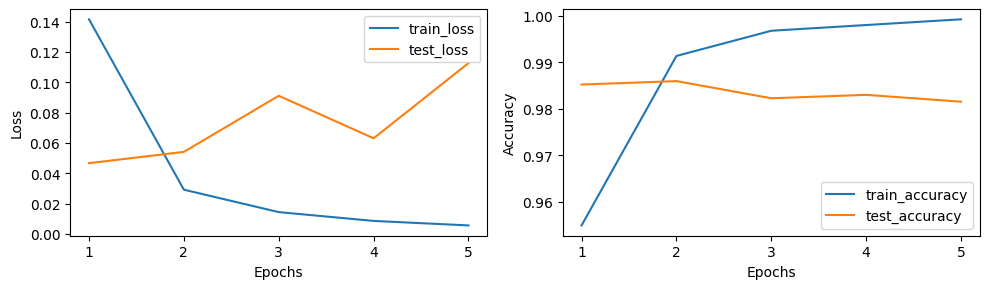

In [156]:
plot_model_performance(lstm_hist)

In [176]:
lstm_best_model = tf.keras.models.load_model("./saved_models/lstm_model/")

In [177]:
y_pred4 = np.round(lstm_best_model.predict(X_test))

43/43 [==============================] - 1s 9ms/step


In [178]:
model_performance(y_test, y_pred4)

{'accuracy': 0.986, 'recall': 0.919, 'precision': 0.97, 'f1_score': 0.944}

### Model5: `GRU`

In [142]:
gru_model = Sequential()
gru_model.add(text_vect)
gru_model.add(embed)
gru_model.add(GRU(units = 64, return_sequences = True))
gru_model.add(GRU(units = 64))
gru_model.add(Dense(units = 128, activation = 'relu'))
gru_model.add(Dense(units = 1, activation = 'sigmoid'))

In [143]:
gru_model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [144]:
gru_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_8 (Text  (None, 20)                0         
 Vectorization)                                                  
                                                                 
 embedding_8 (Embedding)     (None, 20, 256)           716800    
                                                                 
 gru (GRU)                   (None, 20, 64)            61824     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_20 (Dense)            (None, 128)               8320      
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                     

In [145]:
gru_hist = gru_model.fit(x = X_train, y = tf.cast(y_train, dtype = tf.float32), validation_data = (X_test, tf.cast(y_test, dtype = tf.float32)), epochs = 5, callbacks = [model_ckpt("gru_model")])

Epoch 1/5
125/127 [============================>.] - ETA: 0s - loss: 0.1116 - accuracy: 0.9597INFO:tensorflow:Assets written to: ./saved_models\gru_model\assets


INFO:tensorflow:Assets written to: ./saved_models\gru_model\assets


127/127 [==============================] - 23s 131ms/step - loss: 0.1098 - accuracy: 0.9604 - val_loss: 0.0783 - val_accuracy: 0.9823
Epoch 2/5
126/127 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.9980INFO:tensorflow:Assets written to: ./saved_models\gru_model\assets


INFO:tensorflow:Assets written to: ./saved_models\gru_model\assets


127/127 [==============================] - 15s 117ms/step - loss: 0.0076 - accuracy: 0.9980 - val_loss: 0.0911 - val_accuracy: 0.9838
Epoch 3/5
125/127 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9992INFO:tensorflow:Assets written to: ./saved_models\gru_model\assets


INFO:tensorflow:Assets written to: ./saved_models\gru_model\assets


127/127 [==============================] - 15s 120ms/step - loss: 0.0058 - accuracy: 0.9993 - val_loss: 0.0669 - val_accuracy: 0.9845
Epoch 4/5
127/127 [==============================] - 3s 22ms/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.1045 - val_accuracy: 0.9838
Epoch 5/5
127/127 [==============================] - 3s 24ms/step - loss: 0.0047 - accuracy: 0.9995 - val_loss: 0.0802 - val_accuracy: 0.9845


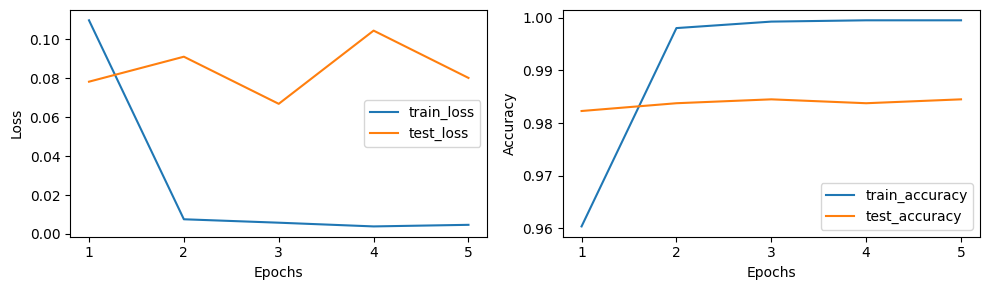

In [157]:
plot_model_performance(gru_hist)

In [167]:
gru_best_model = tf.keras.models.load_model("./saved_models/gru_model/")

In [169]:
y_pred5 = np.round(gru_best_model.predict(X_test))
model_performance(y_test, y_pred5)

43/43 [==============================] - 0s 10ms/step


{'accuracy': 0.985, 'recall': 0.908, 'precision': 0.969, 'f1_score': 0.937}

### Model6: `Bidirectional`

In [159]:
bi_model = Sequential()
bi_model.add(text_vect)
bi_model.add(embed)
bi_model.add(Bidirectional(LSTM(units = 64, return_sequences = True)))
bi_model.add(Bidirectional(GRU(units = 64)))
bi_model.add(Dense(units = 128, activation = 'relu'))
bi_model.add(Dense(units = 1, activation = 'sigmoid'))

In [160]:
bi_model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [161]:
bi_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_8 (Text  (None, 20)                0         
 Vectorization)                                                  
                                                                 
 embedding_8 (Embedding)     (None, 20, 256)           716800    
                                                                 
 bidirectional (Bidirection  (None, 20, 128)           164352    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                     

In [162]:
bi_hist = bi_model.fit(x = X_train, y = tf.cast(y_train, dtype = tf.float32), validation_data = (X_test, tf.cast(y_test, dtype = tf.float32)), epochs = 5, callbacks = [model_ckpt("bidirectional_model")])

Epoch 1/5
127/127 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9788INFO:tensorflow:Assets written to: ./saved_models\bidirectional_model\assets


INFO:tensorflow:Assets written to: ./saved_models\bidirectional_model\assets


127/127 [==============================] - 57s 373ms/step - loss: 0.0607 - accuracy: 0.9788 - val_loss: 0.0776 - val_accuracy: 0.9801
Epoch 2/5
127/127 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9995INFO:tensorflow:Assets written to: ./saved_models\bidirectional_model\assets


INFO:tensorflow:Assets written to: ./saved_models\bidirectional_model\assets


127/127 [==============================] - 44s 352ms/step - loss: 0.0052 - accuracy: 0.9995 - val_loss: 0.0959 - val_accuracy: 0.9808
Epoch 3/5
127/127 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9995INFO:tensorflow:Assets written to: ./saved_models\bidirectional_model\assets


INFO:tensorflow:Assets written to: ./saved_models\bidirectional_model\assets


127/127 [==============================] - 45s 357ms/step - loss: 0.0037 - accuracy: 0.9995 - val_loss: 0.1058 - val_accuracy: 0.9838
Epoch 4/5
127/127 [==============================] - 5s 38ms/step - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.1410 - val_accuracy: 0.9756
Epoch 5/5
127/127 [==============================] - 5s 38ms/step - loss: 0.0072 - accuracy: 0.9988 - val_loss: 0.0940 - val_accuracy: 0.9808


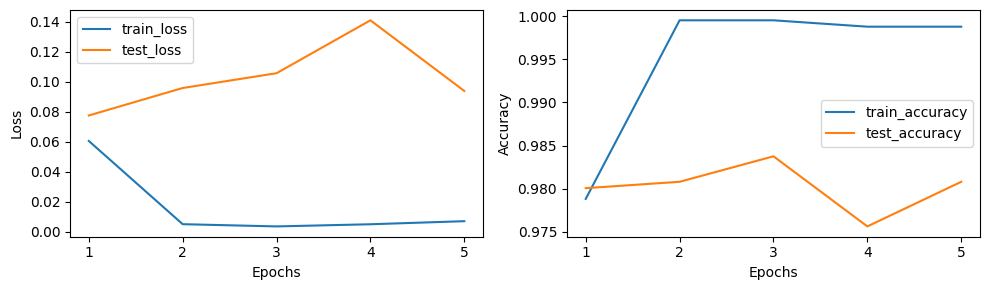

In [163]:
plot_model_performance(bi_hist)

In [164]:
bi_best_model = tf.keras.models.load_model("./saved_models/bidirectional_model/")

In [166]:
y_pred6 = np.round(bi_best_model.predict(X_test))
model_performance(y_test, y_pred6)

43/43 [==============================] - 1s 17ms/step


{'accuracy': 0.984, 'recall': 0.873, 'precision': 1.0, 'f1_score': 0.932}

### Model7: `Conv1D`

In [313]:
input = Input(shape = (1, ), dtype = tf.string)
x = text_vect(input)
x = embed(x)
x = Conv1D(filters = 64, strides = 1, kernel_size = 3, padding = 'valid', activation = 'relu')(x)
x = MaxPooling1D(pool_size = 2, strides = 1, padding = 'same')(x)
x = Conv1D(filters = 64, strides = 1, kernel_size = 3, padding = 'same', activation = 'relu')(x)
x = MaxPooling1D(pool_size = 2, strides = 1, padding = 'valid')(x)
x = Flatten()(x)
x = Dense(units = 128, activation = 'relu')(x)
output = Dense(units = 1, activation = 'sigmoid')(x)

conv_model = Model(input, output)

In [314]:
conv_model.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [315]:
conv_model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_8 (Text  (None, 20)                0         
 Vectorization)                                                  
                                                                 
 embedding_8 (Embedding)     (None, 20, 256)           716800    
                                                                 
 conv1d_42 (Conv1D)          (None, 18, 64)            49216     
                                                                 
 max_pooling1d_40 (MaxPooli  (None, 18, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_43 (Conv1D)          (None, 18, 64)            123

In [316]:
conv_hist = conv_model.fit(x = X_train, y = tf.cast(y_train, dtype = tf.float32), validation_data = (X_test, tf.cast(y_test, dtype = tf.float32)), epochs = 5, callbacks = [model_ckpt("conv1d_model")])

Epoch 1/5


125/127 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.9877INFO:tensorflow:Assets written to: ./saved_models\conv1d_model\assets


INFO:tensorflow:Assets written to: ./saved_models\conv1d_model\assets


127/127 [==============================] - 7s 42ms/step - loss: 0.0286 - accuracy: 0.9879 - val_loss: 0.2608 - val_accuracy: 0.9712
Epoch 2/5
125/127 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990INFO:tensorflow:Assets written to: ./saved_models\conv1d_model\assets


INFO:tensorflow:Assets written to: ./saved_models\conv1d_model\assets


127/127 [==============================] - 4s 28ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.3037 - val_accuracy: 0.9815
Epoch 3/5
127/127 [==============================] - 1s 9ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.3065 - val_accuracy: 0.9771
Epoch 4/5
127/127 [==============================] - 1s 9ms/step - loss: 5.7696e-04 - accuracy: 0.9998 - val_loss: 0.3411 - val_accuracy: 0.9793
Epoch 5/5
127/127 [==============================] - 1s 9ms/step - loss: 4.2803e-04 - accuracy: 0.9998 - val_loss: 0.3624 - val_accuracy: 0.9801


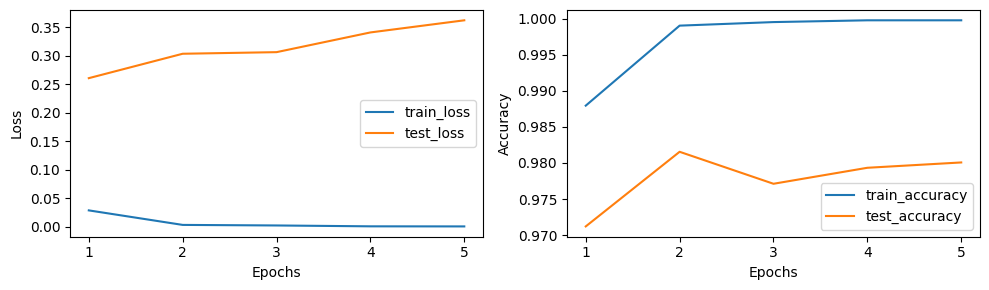

In [317]:
plot_model_performance(conv_hist)

In [318]:
conv_best_model = tf.keras.models.load_model('./saved_models/conv1d_model/')

In [319]:
y_pred7 = np.round(conv_best_model(X_test))
model_performance(y_test, y_pred7)

{'accuracy': 0.982, 'recall': 0.919, 'precision': 0.935, 'f1_score': 0.927}

## **Model Performance Summary**

In [324]:
mnb = model_performance(y_test, y_pred)
svc = model_performance(y_test, y_pred2)
rdf = model_performance(y_test, y_pred3)
lstm = model_performance(y_test, y_pred4)
gru = model_performance(y_test, y_pred5)
bi = model_performance(y_test, y_pred6)
conv = model_performance(y_test, y_pred7)

In [326]:
model_performance_data = pd.DataFrame(
    [mnb.values(),
    svc.values(),
    rdf.values(),
    lstm.values(),
    gru.values(),
    bi.values(),
    conv.values()],
    columns = ["Accuracy", "Recall", "Precision", "F1_score"],
    index = ["Multinomial NB", "SVC", "Random Forest", "LSTM", "GRU", "Bidirectional", "Conv1D"]
)

In [330]:
model_performance_data.sort_values(by = "F1_score", ascending = False).style.background_gradient()

,Accuracy,Recall,Precision,F1_score
LSTM,0.986000,0.919000,0.970000,0.944000
GRU,0.985000,0.908000,0.969000,0.937000
Bidirectional,0.984000,0.873000,1.000000,0.932000
Conv1D,0.982000,0.919000,0.935000,0.927000
Random Forest,0.982000,0.861000,1.000000,0.925000
SVC,0.979000,0.855000,0.980000,0.914000
Multinomial NB,0.970000,0.786000,0.978000,0.872000
